 ## Bycycle image capture analysis

### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


### Reading json data to pandas dataframe

#### loading the ``anonymized_project file``

In [80]:
#open and loading the anonymized_project file
with open('../data/anonymized_project.json') as f:
    j = json.load(f)
data=j['results']['root_node']['results']
df = pd.json_normalize(data.values()).apply(pd.Series.explode).reset_index(drop=True)
# remove and normalize the column of dictionaries, and join the result to df
df = df.join(pd.json_normalize(df.pop('results')))
#here we should drop project_node_input_id' record from the df, here i assume the input id should be unique
df = df.drop_duplicates(subset='project_node_input_id', keep="first")
df.head()


,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url
0,discrete_answer,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
10,discrete_answer,2021-02-25T13:53:31.698130+00:00,5,0.0,9d8a2527-accb-40bd-90d8-a73f20a609be,0000de80-97c8-40f4-aee1-f30377174381,9d8a2527-accb-40bd-90d8-a73f20a609be,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1044,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...
20,discrete_answer,2021-02-25T13:35:02.076869+00:00,5,0.0,0625d00c-96c3-41ad-9324-37037ffd0325,00023262-3608-4678-8d3f-142e6758fadb,0625d00c-96c3-41ad-9324-37037ffd0325,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,848,vendor_01,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,https://qm-auto-annotator.s3.eu-central-1.amaz...
30,discrete_answer,2021-02-26T03:53:40.752056+00:00,5,0.0,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,00036ee9-f7da-4753-9607-7df7b57d4623,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1077,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,https://qm-auto-annotator.s3.eu-central-1.amaz...
40,discrete_answer,2021-02-25T10:19:19.501386+00:00,5,0.0,363aaded-07f3-41b1-8c84-4bae83406757,000468b7-a24c-435c-b506-9db1bf3c700d,363aaded-07f3-41b1-8c84-4bae83406757,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1742,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...


#### Ectracting  ``img_``  string from ``root_input.image_url`` 

In [3]:
df['img'] = df['root_input.image_url'].str.extract('(img_\d+)')
df.reset_index(drop=True)

,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,img
0,discrete_answer,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686
1,discrete_answer,2021-02-25T13:53:31.698130+00:00,5,0.0,9d8a2527-accb-40bd-90d8-a73f20a609be,0000de80-97c8-40f4-aee1-f30377174381,9d8a2527-accb-40bd-90d8-a73f20a609be,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1044,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_8607
2,discrete_answer,2021-02-25T13:35:02.076869+00:00,5,0.0,0625d00c-96c3-41ad-9324-37037ffd0325,00023262-3608-4678-8d3f-142e6758fadb,0625d00c-96c3-41ad-9324-37037ffd0325,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,848,vendor_01,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_5541
3,discrete_answer,2021-02-26T03:53:40.752056+00:00,5,0.0,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,00036ee9-f7da-4753-9607-7df7b57d4623,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1077,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3218
4,discrete_answer,2021-02-25T10:19:19.501386+00:00,5,0.0,363aaded-07f3-41b1-8c84-4bae83406757,000468b7-a24c-435c-b506-9db1bf3c700d,363aaded-07f3-41b1-8c84-4bae83406757,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1742,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9082,discrete_answer,2021-02-26T04:06:28.213617+00:00,5,0.0,0ea47243-a5ba-4bea-a61e-632ca41ab503,8c3b0939-0ea0-4326-b32c-525e026f74d4,0ea47243-a5ba-4bea-a61e-632ca41ab503,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,918,vendor_01,32971d11-e972-4d73-99a6-0847e1261995,annotator_18,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_5282
9083,discrete_answer,2021-02-25T12:50:45.388598+00:00,5,0.0,9ac9d365-9dd7-44fc-9e3e-5772110bb217,8df11808-4d11-49b7-97ff-3a61f618f45c,9ac9d365-9dd7-44fc-9e3e-5772110bb217,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1415,vendor_01,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_0628
9084,discrete_answer,2021-02-25T15:10:56.190173+00:00,5,0.0,bf4f4d43-de3b-46ef-8ed4-4d04d4641187,92ccde6e-1302-40e1-9f82-454179b7f1ae,bf4f4d43-de3b-46ef-8ed4-4d04d4641187,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1047,vendor_01,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_7736
9085,discrete_answer,2021-02-25T14:42:36.468576+00:00,5,0.0,cfa36c30-31ab-4647-bbc0-7e505db482ac,93799099-e674-43c3-a3e8-d8b872aad0eb,cfa36c30-31ab-4647-bbc0-7e505db482ac,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,911,vendor_01,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_1042


In [4]:
df.columns

Index(['gui_type', 'created_at', 'workpackage_total_size', 'loss',
       'project_node_input_id', 'project_node_output_id',
       'project_root_node_input_id', 'task_input.image_url',
       'task_output.answer', 'task_output.cant_solve',
       'task_output.corrupt_data', 'task_output.duration_ms', 'user.vendor_id',
       'user.id', 'user.vendor_user_id', 'root_input.image_url', 'img'],
      dtype='object')

#### Loading the ``references.json file``

In [5]:
with open('../data/references.json') as f:
    j1 = json.load(f)
df1 = pd.json_normalize(j1).T
df1=pd.json_normalize(j1,max_level=0).T
df1.columns=['result']
# Create a new column with index values
#df1['img'] = df1.index

#using reset_index() to set index into column
df2=df1.reset_index()
df2=df2.rename(columns={'index':'img'})
df2=pd.concat([df2.drop(['result'], axis=1), df2['result'].apply(pd.Series)], axis=1)
df2.isnull().sum()


img           0
is_bicycle    0
dtype: int64

### Joining two data frames  on ``img`` column

In [6]:
df_new=pd.merge(df, df2, on='img')
df_new.head()

,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,img,is_bicycle
0,discrete_answer,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,False
1,discrete_answer,2021-02-25T13:53:31.698130+00:00,5,0.0,9d8a2527-accb-40bd-90d8-a73f20a609be,0000de80-97c8-40f4-aee1-f30377174381,9d8a2527-accb-40bd-90d8-a73f20a609be,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1044,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_8607,True
2,discrete_answer,2021-02-25T13:35:02.076869+00:00,5,0.0,0625d00c-96c3-41ad-9324-37037ffd0325,00023262-3608-4678-8d3f-142e6758fadb,0625d00c-96c3-41ad-9324-37037ffd0325,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,848,vendor_01,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_5541,False
3,discrete_answer,2021-02-26T03:53:40.752056+00:00,5,0.0,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,00036ee9-f7da-4753-9607-7df7b57d4623,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1077,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3218,False
4,discrete_answer,2021-02-25T10:19:19.501386+00:00,5,0.0,363aaded-07f3-41b1-8c84-4bae83406757,000468b7-a24c-435c-b506-9db1bf3c700d,363aaded-07f3-41b1-8c84-4bae83406757,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1742,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3247,True


In [7]:
df_new.shape

(9087, 18)

### Saving to csv file 

In [8]:
df_new.to_csv('../data/finaldata.csv')

### Reading from csv file to dataframe

In [19]:
df_new=pd.read_csv('../data/finaldata.csv')

### Understanding data

In [20]:
df_new.reset_index(drop=True)
df_new.drop(columns='Unnamed: 0',inplace=True)
df_new.shape

(9087, 18)

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gui_type                    9087 non-null   object 
 1   created_at                  9087 non-null   object 
 2   workpackage_total_size      9087 non-null   int64  
 3   loss                        9087 non-null   float64
 4   project_node_input_id       9087 non-null   object 
 5   project_node_output_id      9087 non-null   object 
 6   project_root_node_input_id  9087 non-null   object 
 7   task_input.image_url        9087 non-null   object 
 8   task_output.answer          9085 non-null   object 
 9   task_output.cant_solve      9087 non-null   bool   
 10  task_output.corrupt_data    9087 non-null   bool   
 11  task_output.duration_ms     9087 non-null   int64  
 12  user.vendor_id              9087 non-null   object 
 13  user.id                     9087 

- The file contains 9087 records and 18 features.
- Almost all columns data is chategorcial except time columns

### Data Cleaning 

#### `` gui_type feature``

In [22]:
df_new.gui_type.value_counts()

discrete_answer    9087
Name: gui_type, dtype: int64

- There is only one type of answer with 'gui_type'  so it will not help to us to anaysis data.
- 'task_input.image_url' and 'root_input.image_url' also not help for further data analysis.
 ### checking column value dupication 

In [23]:
df_new['project_node_input_id'].equals(df_new['project_root_node_input_id'])

True

-  Here ``project_node_input_id`` column is duplicated with ``project_root_node_input_id`` column,so decided to drop one of them.

In [24]:
df_new['task_output.cant_solve'].value_counts()

False    9085
True        2
Name: task_output.cant_solve, dtype: int64

- Here ``task_output.cant_solve`` column contains only two images with True

In [25]:
df_new['task_output.corrupt_data'].value_counts()

False    9087
Name: task_output.corrupt_data, dtype: int64

- Here ``task_output.corrupt_data`` have only one category 'False' ,so data is not correpted.

In [26]:
df_new.img.isnull().sum()

0

In [27]:
df_new['is_bicycle'].isnull().sum()

0

- Here img and is_bicycle column dont have any null values.

In [28]:
df_new['user.vendor_id'].value_counts()

vendor_01    9087
Name: user.vendor_id, dtype: int64

- Here ``user.vendor_id`` have only one category,it will not help much for analysis ,decided to drop.

In [29]:
df_new['workpackage_total_size'].value_counts()


5    9082
1       2
2       2
3       1
Name: workpackage_total_size, dtype: int64

- Here total 4 workpakaege groups given.

In [30]:
df_new['loss'].value_counts()

0.0    9087
Name: loss, dtype: int64

- Here ``Loss`` column  also not giving much infromation,so decided to drop.

In [31]:
df_new['task_output.answer'].value_counts()


yes    4618
no     4467
Name: task_output.answer, dtype: int64

- Here the ``task_output.answer``  column  almost eqally  provided results.

In [32]:
df_new.loc[(df_new['task_output.answer']!='yes') & (df_new['task_output.answer'] != 'no')]

,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,img,is_bicycle
7024,discrete_answer,2021-02-25T13:16:11.077555+00:00,5,0.0,035315c3-ef9b-47c9-b48a-a6dca661b38c,234248a6-016b-451d-9e77-110ae1e7c92f,035315c3-ef9b-47c9-b48a-a6dca661b38c,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,True,False,746,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193,annotator_04,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_6009,True
8710,discrete_answer,2021-02-25T10:10:08.355604+00:00,5,0.0,bc616814-9d98-4c9f-afcb-d921d166653a,46f706a4-39ad-443a-ba86-b23ec8a56cd4,bc616814-9d98-4c9f-afcb-d921d166653a,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,True,False,783,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_1963,True


In [33]:
df_new.loc[df_new['task_output.answer'] == '', 'task_output.answer'] = 'cant_solve&corrupt_data'
task_df=df_new.loc[(df_new['task_output.answer']!='yes') & (df_new['task_output.answer'] != 'no')].reset_index()
task_df.groupby('user.vendor_user_id')[['task_output.answer','task_output.cant_solve','task_output.corrupt_data']].sum()

,task_output.cant_solve,task_output.corrupt_data
user.vendor_user_id,,
annotator_04,1,0
annotator_20,1,0


#### Insights:
- There is no case with  corrupted data.Only two cases can't solved by some other reasons.


#### Dropping unnecessary columns

In [34]:
df = df_new.drop(columns=['gui_type', 'task_input.image_url','root_input.image_url','project_root_node_input_id','user.id',
                          'user.vendor_id','loss','project_node_input_id',
                          'project_node_output_id','img'],axis=1)
df.head()

,created_at,workpackage_total_size,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_user_id,is_bicycle
0,2021-02-25T14:08:11.319438+00:00,5,no,False,False,997,annotator_12,False
1,2021-02-25T13:53:31.698130+00:00,5,yes,False,False,1044,annotator_11,True
2,2021-02-25T13:35:02.076869+00:00,5,no,False,False,848,annotator_05,False
3,2021-02-26T03:53:40.752056+00:00,5,no,False,False,1077,annotator_06,False
4,2021-02-25T10:19:19.501386+00:00,5,yes,False,False,1742,annotator_20,True


In [35]:
df.shape

(9087, 8)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   created_at                9087 non-null   object
 1   workpackage_total_size    9087 non-null   int64 
 2   task_output.answer        9085 non-null   object
 3   task_output.cant_solve    9087 non-null   bool  
 4   task_output.corrupt_data  9087 non-null   bool  
 5   task_output.duration_ms   9087 non-null   int64 
 6   user.id                   9087 non-null   object
 7   user.vendor_user_id       9087 non-null   object
 8   is_bicycle                9087 non-null   bool  
dtypes: bool(3), int64(2), object(4)
memory usage: 452.7+ KB


-  After Droping columns we got 8 features for further analysis

### Checking  null Values

In [36]:
#  Print the columns with missing values
[col for col in df.columns if df[col].isnull().any()]

['task_output.answer']

<Axes: >

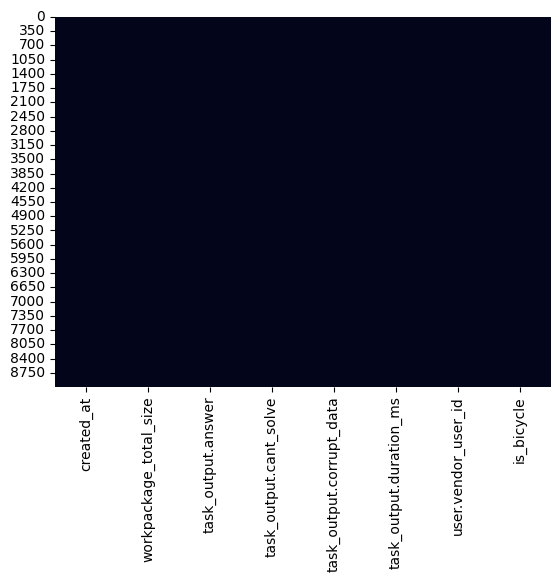

In [37]:
sns.heatmap(df.isnull(), cbar=False)

#### Insights:
- There are 2 instances from ``task_output.answer``column have null values.


### filling null values with ``no_output`` string

In [38]:
df.fillna('no_output', inplace=True)
df.isnull().sum()

created_at                  0
workpackage_total_size      0
task_output.answer          0
task_output.cant_solve      0
task_output.corrupt_data    0
task_output.duration_ms     0
user.vendor_user_id         0
is_bicycle                  0
dtype: int64

### Converting ``created_at``  column to date time format

In [39]:
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
#df['task_output.duration_ms'] = pd.to_time(df['task_output.duration_ms'], unit = 'ms')
#df['task_output.duration_ms'] = pd.to_timedelta(df['task_output.duration_ms'])
#df['task_output.duration_ms']=df['task_output.duration_ms'].strftime('%s%f')[:-3]
df.created_at.dtype

datetime64[ns, UTC]

In [40]:
df.created_at.dt.day.value_counts()

25    7208
26    1879
Name: created_at, dtype: int64

#### All the data is spread over 2 days.

### Exploratory Data Analysis

### functions for visualization and percentage calculation

In [41]:
## Function to visualise annotators
def annotator_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel('annotators')
    plt.ylabel('count')
    # Show graph
    plt.show()
#vendor_visual(filter_df,'user.vendor_user_id')    


In [42]:
##Function to calculate annotators percentage
def annot_percent(df,column):
    df_=df[column].value_counts().to_frame().reset_index().rename(columns={'index':'annotator'})
    df_['annotator %'] = ((df_[column] / df_[column] .sum())*100).round(2).astype(str) + '%'
    return df_

### Tasks
#### 1. Gather insights about the annotators:
 #### - a.  How many annotators did contribute to the dataset?

In [43]:
a=df['user.vendor_user_id'].value_counts().count()
print('The total annotators are contributing to the datase:', a)

The total annotators are contributing to the datase: 22


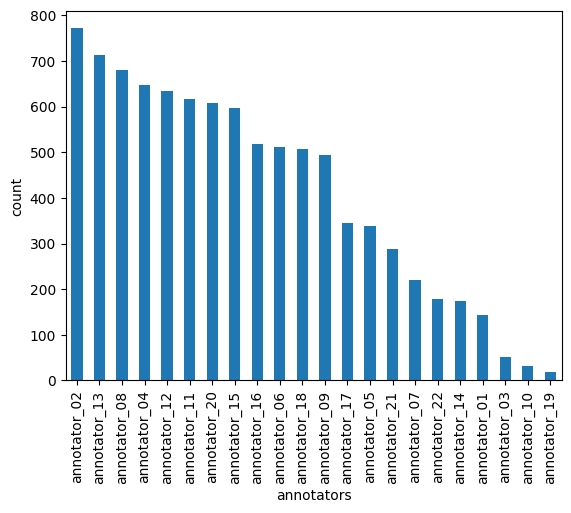

In [44]:
annotator_visual(df.copy(),'user.vendor_user_id') 

#### Insights from annotators class
- There are 22 annotators in total
-  More number of responses(771) provided by ``annotator-2`` and the less responses by ``annotator-19(19)``.




#### 1.b. What are the average, min and max annotation times (durations)? Feel free toadd visual representations here such as graphs if you like.

In [45]:
#df.groupby('user.vendor_user_id')['task_output.duration_ms'].agg()
df_time=df.groupby(['user.vendor_user_id'])['task_output.duration_ms'].agg([('Min' , 'min'), ('Max', 'max'),
                                                                                              ('mean','mean')]).add_prefix('tasktime_').reset_index().sort_values(['tasktime_Min',
                                                                                              'tasktime_Max','tasktime_mean'])
df_time


,user.vendor_user_id,tasktime_Min,tasktime_Max,tasktime_mean
19,annotator_20,70,7753,1179.331137
7,annotator_08,166,14310,1413.185022
21,annotator_22,349,3300,890.217877
10,annotator_11,479,11079,1256.322528
9,annotator_10,486,7302,1284.709677
16,annotator_17,495,3583,986.675362
20,annotator_21,495,9999,1193.451389
6,annotator_07,525,10672,1450.868182
8,annotator_09,558,13385,1199.093117
3,annotator_04,565,10389,1146.992272


### Insights

- Form the above data ``annotator_20`` took min time ``70ms`` to respond and ``annotator_14`` took max time ``24757ms`` to respond.
- Both cases the output answer is ``yes``.

### Lets see visually the  Avg,max and min task time


<Figure size 2000x1000 with 0 Axes>

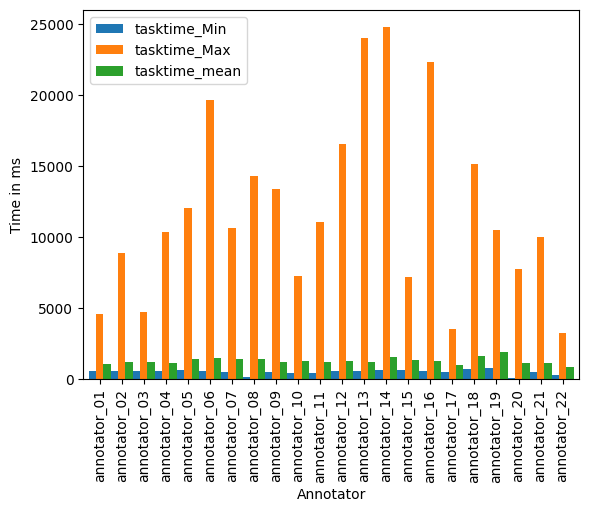

<Figure size 2000x1000 with 0 Axes>

In [46]:
df_time.groupby(['user.vendor_user_id']).sum().plot(kind='bar',width=1)
plt.xlabel("Annotator")
plt.ylabel("Time in ms")
plt.figure(figsize=(20,10))

<Figure size 2000x1000 with 0 Axes>

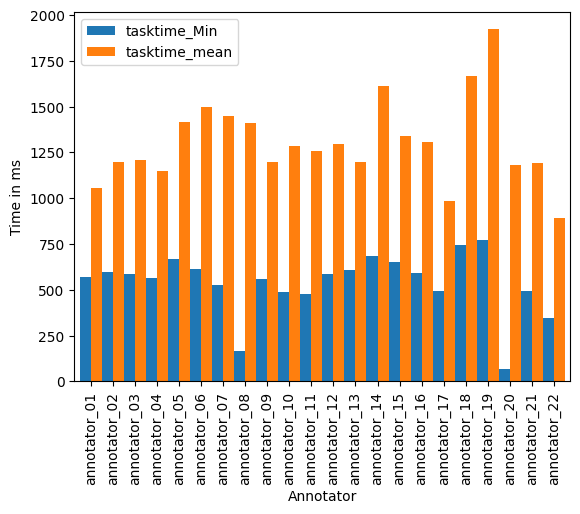

<Figure size 2000x1000 with 0 Axes>

In [47]:
df_time.groupby(['user.vendor_user_id'])[['tasktime_Min','tasktime_mean']].sum().plot(kind='bar',width=1
                                                                                     )
plt.xlabel("Annotator")
plt.ylabel("Time in ms")
plt.figure(figsize=(20,10))


#### 1.c. Did all annotators produce the same amount of results, or are there differences?

In [48]:
##Calling annot_percent function to calcutlate percentage
annot_percent(df.copy(),'user.vendor_user_id')

,annotator,user.vendor_user_id,annotator %
0,annotator_02,771,8.48%
1,annotator_13,712,7.84%
2,annotator_08,681,7.49%
3,annotator_04,647,7.12%
4,annotator_12,634,6.98%
5,annotator_11,617,6.79%
6,annotator_20,607,6.68%
7,annotator_15,597,6.57%
8,annotator_16,517,5.69%
9,annotator_06,512,5.63%


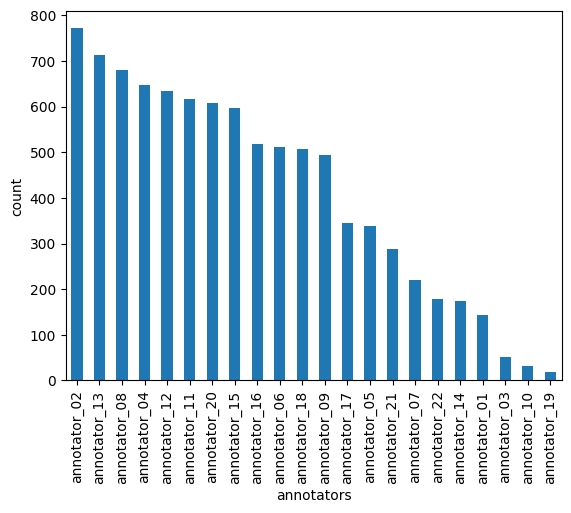

In [49]:
#calling annotator function
annotator_visual(df.copy(),'user.vendor_user_id')

#### Insights
- From the above analysis all annotators are not producing same amount of results.
- ``Annotator-2`` is producing more results(8.48%).
- ``Annotatos -19`` is producing least results(0.21%)

#### 2. Besides picking yes or no the annotators had the chance to tell if the data werecorrupted or if they for any reason were not able to solve the task. These are fields'cant_solve' and 'corrupt_data' given in the task_output.a. How often does each occur in the project and do you see a trend within theannotators that made use of these options?

In [50]:
df.loc[(df['task_output.answer']!='yes') & (df['task_output.answer'] != 'no')].reset_index(drop=True)

,created_at,workpackage_total_size,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_user_id,is_bicycle
0,2021-02-25 13:16:11.077555+00:00,5,no_output,True,False,746,annotator_04,True
1,2021-02-25 10:10:08.355604+00:00,5,no_output,True,False,783,annotator_20,True


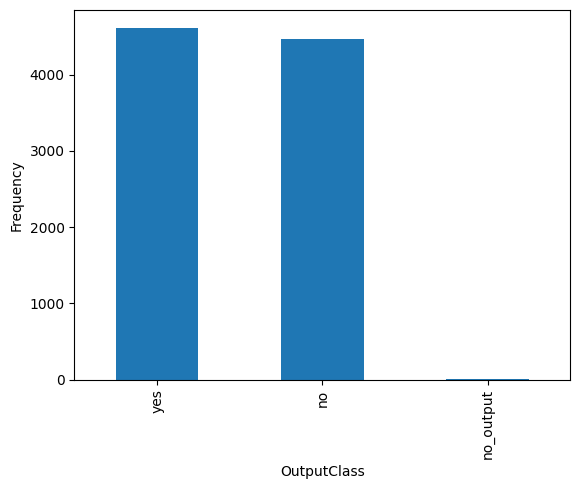

In [51]:
def task_output_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel("OutputClass")
    plt.ylabel("Frequency")
    # Show graph
    plt.show()
task_output_visual(df.copy(),'task_output.answer')

([<matplotlib.patches.Wedge at 0x163080f39d0>,
 [Text(-0.028328848581519364, 1.099635156012232, 'yes'),
  Text(0.027568414217594386, -1.099654483252593, 'no'),
  Text(1.099999736924084, -0.0007607673403678934, 'no_output')],
 [Text(-0.015452099226283288, 0.5998009941884901, '50.8%\n4618'),
  Text(0.015037316845960571, -0.5998115363195962, '49.2%\n4467'),
  Text(0.5999998565040457, -0.00041496400383703267, '0.0%\n2')])

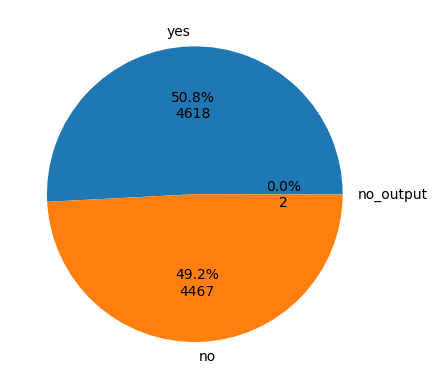

In [54]:
task_output = df['task_output.answer'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, task_output *x/100)

plt.pie(df['task_output.answer'].value_counts().values, labels=df['task_output.answer'].value_counts().index, autopct=fmt)

In [55]:
df.groupby('user.vendor_user_id')['task_output.answer'].value_counts().to_frame().unstack().fillna(0)

task_output.answer                 
task_output.answer                  no no_output    yes
user.vendor_user_id                                    
annotator_01                      65.0       0.0   79.0
annotator_02                     370.0       0.0  401.0
annotator_03                      25.0       0.0   26.0
annotator_04                     300.0       1.0  346.0
annotator_05                     174.0       0.0  164.0
annotator_06                     229.0       0.0  283.0
annotator_07                     110.0       0.0  110.0
annotator_08                     323.0       0.0  358.0
annotator_09                     225.0       0.0  269.0
annotator_10                      13.0       0.0   18.0
annotator_11                     332.0       0.0  285.0
annotator_12                     277.0       0.0  357.0
annotator_13                     364.0       0.0  348.0
annotator_14                     108.0       0.0   67.0
annotator_15                     297.0       0.0  300.0
annotator_16                     279.0       0.0  238.0
annotator_17                     199.0       0.0  146.0
annotator_18                     245.0       0.0  263.0
annotator_19                      11.0       0.0    8.0
annotator_20                     296.0       1.0  310.0
annotator_21                     142.0       0.0  146.0
annotator_22                      83.0       0.0   96.0

### Observations
- There are only two instances occured with can't solve output .
- There are no instances that output corrupt_ data is true.

#### 3. Is the reference set balanced? Please demonstrate via numbers and visualizations.

In [56]:
df['is_bicycle'].value_counts().to_frame()

,is_bicycle
True,4586
False,4501


### Insights
- From the above information is_bicycle class is  equaly distributed.
- Lets see visually how data fall.

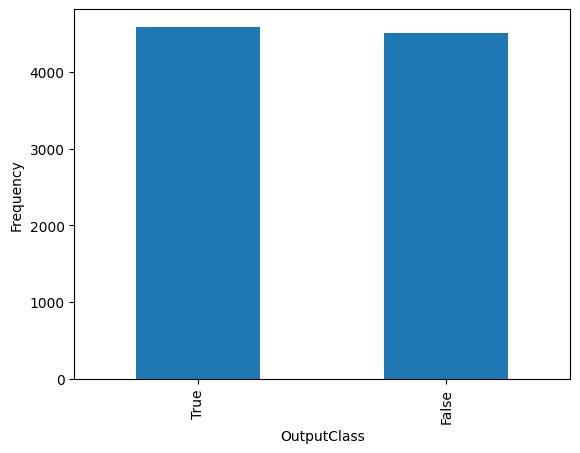

In [57]:
def is_bicycle_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel("BiclycleClass")
    plt.ylabel("Frequency")
    # Show graph
    plt.show()
task_output_visual(df.copy(),'is_bicycle')

([<matplotlib.patches.Wedge at 0x1630bd806d0>,
 [Text(-0.016161962092938756, 1.0998812622193845, 'True'),
  Text(0.016161962092938135, -1.0998812622193845, 'False')],
 [Text(-0.008815615687057502, 0.5999352339378461, '50.5%\n4586'),
  Text(0.008815615687057164, -0.5999352339378461, '49.5%\n4501')])

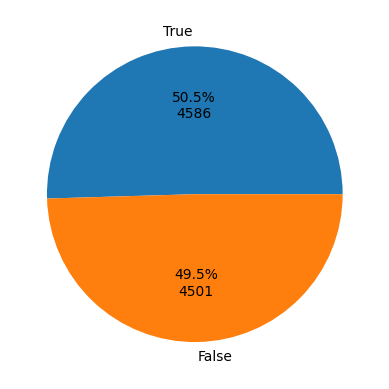

In [58]:
total = df['is_bicycle'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(df['is_bicycle'].value_counts().values, labels=df['is_bicycle'].value_counts().index, autopct=fmt)

### 4. Using the reference set, can you identify good and bad annotators? Please use


### Filter data columns for further analysis
- Here the data frame I am taking excluding with can't solve True records.

In [59]:
filter_df = df.filter(['user.vendor_user_id','task_output.answer','task_output.duration_ms','is_bicycle'], axis=1)
filter_df=filter_df.loc[(filter_df['task_output.answer']=='yes') | (filter_df['task_output.answer'] == 'no')]
filter_df.head()

,user.vendor_user_id,task_output.answer,task_output.duration_ms,is_bicycle
0,annotator_12,no,997,False
1,annotator_11,yes,1044,True
2,annotator_05,no,848,False
3,annotator_06,no,1077,False
4,annotator_20,yes,1742,True


In [60]:
filter_df.shape


#filter_df

(9085, 4)

### Mapping True and False Predciton
- Here the function can map ``1 ``if ``'task_output.answer'= 'yes'& 'is_bicycle'=True``Or if ``'task_output.answer'= 'no'& 'is_bicycle'=False``
- Other wise return ``0``

In [62]:
#A function to filter corect values by comaring task_output.answer and is_bicycle' column
def myFun(rec):
    if (rec['task_output.answer']== 'yes') & (rec['is_bicycle']==True):
        return 1
    elif (rec['task_output.answer']== 'no') & (rec['is_bicycle']==False):
        return 1
    
    return 0
   
filter_df['result']=filter_df.apply(myFun,axis=1)
    

In [63]:
filter_df

,user.vendor_user_id,task_output.answer,task_output.duration_ms,is_bicycle,result
0,annotator_12,no,997,False,1
1,annotator_11,yes,1044,True,1
2,annotator_05,no,848,False,1
3,annotator_06,no,1077,False,1
4,annotator_20,yes,1742,True,1
...,...,...,...,...,...
9082,annotator_18,yes,918,True,1
9083,annotator_09,yes,1415,True,1
9084,annotator_02,yes,1047,True,1
9085,annotator_09,no,911,False,1


### Calculating Percentages of  ture&false classes from  total responses

In [64]:
annot_job__percent=filter_df.groupby(['user.vendor_user_id'])['result'].value_counts().unstack(fill_value=0).reset_index()
#df_fill.rename()
annot_job__percent.rename(columns={0:'false',1:'true'},inplace=True)
annot_job__percent['annot_total']=annot_job__percent['false'] + annot_job__percent['true']
annot_job__percent['true_%_from_all_annot'] = (annot_job__percent['true'] / annot_job__percent['annot_total'].sum() * 100).round(2)
annot_job__percent['false_%_from_all_annot'] = (annot_job__percent['false'] / annot_job__percent['annot_total'].sum() * 100).round(2)
annot_job__percent['true%_from_annot_count']= (annot_job__percent['true'] / annot_job__percent['annot_total'] * 100).round(2)
annot_job__percent['false%_from_annot_count']= (annot_job__percent['false'] / annot_job__percent['annot_total'] * 100).round(2)
annot_job__percent['annot_total_%']= (annot_job__percent['annot_total'] / annot_job__percent['annot_total'].sum() * 100).round(2)
#annot_job__percent=annot_job__percent.sort_values(by='true_%_from_a_total',ascending=False)
annot_job__percent=annot_job__percent.reset_index(drop=True)
columnsTitles = ['user.vendor_user_id', 'annot_total', 'true','false','true%_from_annot_count','false%_from_annot_count',
                 'annot_total_%','true_%_from_all_annot','false_%_from_all_annot']
annot_job__percent = annot_job__percent.reindex(columns=columnsTitles).sort_values(by='true%_from_annot_count',ascending=False)
annot_job__percent.reset_index(drop=True)


result,user.vendor_user_id,annot_total,true,false,true%_from_annot_count,false%_from_annot_count,annot_total_%,true_%_from_all_annot,false_%_from_all_annot
0,annotator_19,19,19,0,100.00,0.00,0.21,0.21,0.00
1,annotator_01,144,138,6,95.83,4.17,1.59,1.52,0.07
2,annotator_16,517,495,22,95.74,4.26,5.69,5.45,0.24
3,annotator_13,712,679,33,95.37,4.63,7.84,7.47,0.36
4,annotator_15,597,567,30,94.97,5.03,6.57,6.24,0.33
5,annotator_17,345,327,18,94.78,5.22,3.80,3.60,0.20
6,annotator_18,508,480,28,94.49,5.51,5.59,5.28,0.31
7,annotator_22,179,169,10,94.41,5.59,1.97,1.86,0.11
8,annotator_03,51,48,3,94.12,5.88,0.56,0.53,0.03
9,annotator_21,288,271,17,94.10,5.90,3.17,2.98,0.19


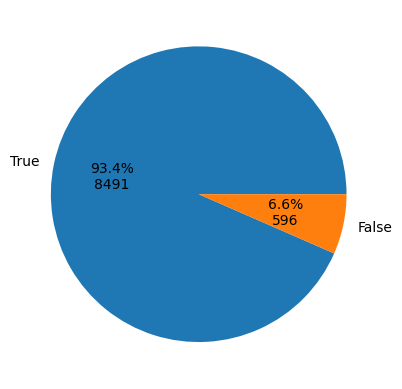

In [65]:
true_sum=annot_job__percent["true"].sum()
false_sum=annot_job__percent["false"].sum()
data=[true_sum,false_sum]
labels=[True,False]
#define Seaborn color palette to use
#colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels,  autopct=fmt)
plt.show()

### Observations
- There annotaor response is 93.4% positive compared with actual results.

In [66]:
filter_df1=filter_df.groupby('user.vendor_user_id')['result'].value_counts().to_frame().rename(columns={'result':'count'})
filter_df1=filter_df1.reset_index()
filter_df.result.value_counts()

1    8489
0     596
Name: result, dtype: int64

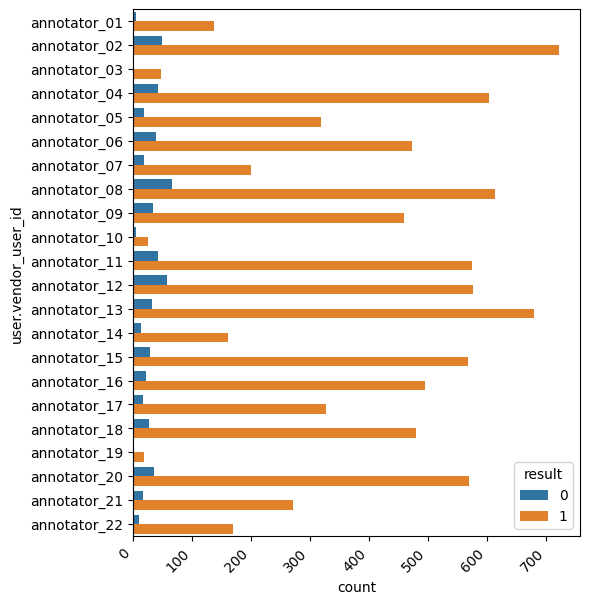

In [67]:
fig, ax1 = plt.subplots(figsize=(6, 6))
g=sns.barplot(data=filter_df1, x='count', y='user.vendor_user_id', hue='result',ax=ax1)
plt.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()



### ObserVations
- Annotator result is compared with the Actual result  and  when it matched it denoted as ``True =1`` and when not it is ``False =0`` .  
- According the %data ``Annotator _19`` is the Good annotator as all the results predicted are ``True`` .`` Annotator _10`` is Bad annotator due to high False prediction . 

- But according to the response contribution to the data set ( 8.5%) and % of True prediction , ``Annotator _02``  is the Best  with ``721 /771(93.5%)`` True predictions . 
 - ``Annotator _10`` is the Bad annotator with second least response to the data set and also % of True predictions .


### Next Steps
- Further detailed analsis with remaining features(eg:time columns)
- Data Engineering
- Model build and evaluate
- Predict



### Data Preprossing
- Here I am excluding task_output.corrupt_data for now.
1. task_output.corrupt_data have only one class(False)  assuming there is no corrupted data 


In [75]:
preprocess_df = df.filter(['user.vendor_user_id','workpackage_total_size','task_output.answer','task_output.duration_ms','is_bicycle'], axis=1)
preprocess_df=preprocess_df.loc[(preprocess_df['task_output.answer']=='yes') | (preprocess_df['task_output.answer'] == 'no')]

preprocess_df

,user.vendor_user_id,workpackage_total_size,task_output.answer,task_output.duration_ms,is_bicycle
0,annotator_12,5,no,997,False
1,annotator_11,5,yes,1044,True
2,annotator_05,5,no,848,False
3,annotator_06,5,no,1077,False
4,annotator_20,5,yes,1742,True
...,...,...,...,...,...
9082,annotator_18,5,yes,918,True
9083,annotator_09,5,yes,1415,True
9084,annotator_02,5,yes,1047,True
9085,annotator_09,5,no,911,False


### Label encoding for chategorcial columns

In [76]:
preprocess_df['task_output.answer'].value_counts()

yes    4618
no     4467
Name: task_output.answer, dtype: int64

In [77]:
##preprocess_df['workpackage_total_size'] = preprocess_df.replace({"'workpackage_total_size'":{5: 0,3: 1,1:2}},inplace=True)
preprocess_df
dict1={5: 0,3: 1,1:2}
preprocess_df['workpackage_total_size'] = preprocess_df['workpackage_total_size'].map({5: 0,3: 1,1:2})
#preprocess_df['task_output.cant_solve'] = preprocess_df['task_output.cant_solve'].map({False:0,True:1})
preprocess_df['task_output.answer'] = preprocess_df['task_output.answer'].map({'yes':1,'no':0})
preprocess_df['is_bicycle'] = preprocess_df['is_bicycle'].map({False:0,True:1})
#Label encodeing for annotators column by using sklean label encoding
le = preprocessing.LabelEncoder()
preprocess_df['user.vendor_user_id'] = le.fit_transform(preprocess_df['user.vendor_user_id'])

#Scalling the task_output_duration column by using min max scaler
scaler = MinMaxScaler()
#preprocess_df['task_output.duration_ms'] = scaler.fit_transform(preprocess_df['task_output.duration_ms'].values.reshape(-1,1))
#
preprocess_d['task_output.duration_ms'] = scaler.fit_transform([preprocess_df['task_output.duration_ms']])

preprocess_df

,user.vendor_user_id,workpackage_total_size,task_output.answer,task_output.duration_ms,is_bicycle
0,11,0.0,0,0.037550,0
1,10,0.0,1,0.039454,1
2,4,0.0,0,0.031515,0
3,5,0.0,0,0.040791,0
4,19,0.0,1,0.067728,1
...,...,...,...,...,...
9082,17,0.0,1,0.034350,1
9083,8,0.0,1,0.054482,1
9084,1,0.0,1,0.039575,1
9085,8,0.0,0,0.034067,0


### Spliting Dataframe into train and test data

In [78]:
X = preprocess_df.drop('is_bicycle',axis=1)
y = preprocess_df['is_bicycle'] 


In [79]:
##Using sklearn train_test_split librabry
x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)